Using device: cuda
Text file /content/data.txt not found. Using toy corpus only.
Total text length: 93
Vocab size: 16
Characters: ['\n', ' ', 'a', 'c', 'e', 'f', 'h', 'l', 'm', 'n', 'o', 'p', 'r', 't', 'u', 'v']
Train samples: 39, Val samples: 4
CharLSTM(
  (embed): Embedding(16, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=16, bias=True)
)
Epoch 01 | Train loss: 2.5974 (ppl=13.43) | Val loss: 2.3086 (ppl=10.06)
Epoch 02 | Train loss: 2.0981 (ppl=8.15) | Val loss: 1.8869 (ppl=6.60)
Epoch 03 | Train loss: 1.6973 (ppl=5.46) | Val loss: 1.5635 (ppl=4.78)
Epoch 04 | Train loss: 1.4121 (ppl=4.10) | Val loss: 1.3131 (ppl=3.72)
Epoch 05 | Train loss: 1.1543 (ppl=3.17) | Val loss: 1.0892 (ppl=2.97)
Epoch 06 | Train loss: 0.9489 (ppl=2.58) | Val loss: 0.8873 (ppl=2.43)
Epoch 07 | Train loss: 0.7853 (ppl=2.19) | Val loss: 0.7183 (ppl=2.05)
Epoch 08 | Train loss: 0.6139 (ppl=1.85) | Val loss: 0.5858 (ppl=1.80)
Epoch 09 | Train loss: 0.5056 (ppl=1.66) 

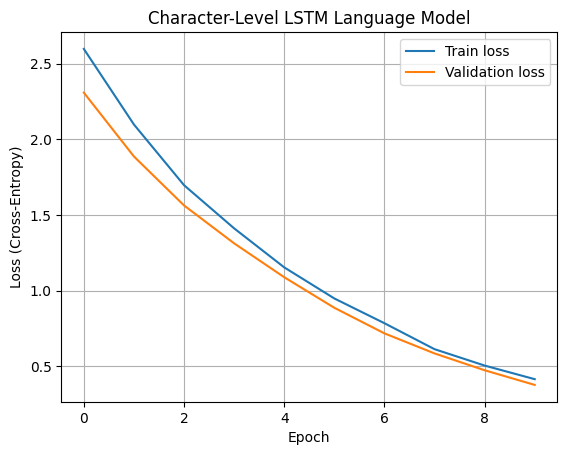

Sample with temperature = 0.7
hello helep help hell oelp help hell hello help hello hello there
help hell hello
helpfu lel arern chelp hello
hello there
hello
hell hello there
help hell hello hello there
hello hello there
help hello
help hell
help hello hello helpul hello help hello
hello help hell hello helpfu help hello help hello
h

Sample with temperature = 1.0
hello helpful helpmfual herahelo
hello help hello
hello there ehe
ulp unl reracuacaracer evel me uel arhac cacracar hellful helpful help hell help hell hello helpfup hello helo hnnlachrello
help hello help hello her
helrelp hello
hello herpeu
help me lrearere 
help helpful help hello help hello
hello help

Sample with temperature = 1.2
hello helphello helpful 
heleloopahelp mmn heea hello
help hel
hep lea
ereu lem lun cah hachareraacterel hel teoe
n herhanrn rhan revm lel here
re lev
nfl haaarpelp hell
hell teren tcaracrer ule help leaha tretren un cacct at
rer enarnnvrcumarnacevr terel t hacearatpfuhel
help hello
hello hele

In [7]:
# ===============================================================

# Pipeline:
#   1) Load text (toy "hello/help" + larger text file if available)
#   2) Build character vocabulary
#   3) Create (input_seq, target_seq) pairs
#   4) Model: Embedding -> LSTM -> Linear -> Softmax over chars
#   5) Train with teacher forcing (cross-entropy, Adam)
#   6) Plot train/val loss
#   7) Generate text with different temperatures (0.7, 1.0, 1.2)
# ===============================================================

import os
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------------------
# 1. Load / Prepare Text Data
# ---------------------------------------------------------------

# I first start with a small toy corpus around "hello" and "help",
# then, if a bigger file exists, I append it to the corpus.
toy_corpus = (
    "hello hello help hell hello helpful help hello\n"
    "hello there\n"
    "help me learn character level rnn\n"
)

# If I upload a bigger public-domain text file (e.g., data.txt),
# I concatenate it here to get something around 50-200 KB.
TEXT_PATH = "/content/data.txt"  # upload in Colab if you want

if os.path.exists(TEXT_PATH):
    with open(TEXT_PATH, "r", encoding="utf-8") as f:
        big_text = f.read()
    print(f"Loaded extra text from {TEXT_PATH}, length:", len(big_text))
    raw_text = toy_corpus + "\n" + big_text
else:
    print(f"Text file {TEXT_PATH} not found. Using toy corpus only.")
    raw_text = toy_corpus

# Convert everything to lowercase for simplicity
raw_text = raw_text.lower()
print("Total text length:", len(raw_text))

# Build character vocabulary from the corpus
chars = sorted(list(set(raw_text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)
print("Characters:", chars)

char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

# Encode the full text as indices
data_indices = [char2idx[c] for c in raw_text]
data_tensor = torch.tensor(data_indices, dtype=torch.long)

# ---------------------------------------------------------------
# 2. Dataset and DataLoader
# ---------------------------------------------------------------

class CharDataset(Dataset):
    """
    Each sample is:
      input_seq:  [c_t, c_{t+1}, ..., c_{t+L-1}]
      target_seq: [c_{t+1}, c_{t+2}, ..., c_{t+L}]
    So the model learns to predict the next char at each position.
    """
    def __init__(self, data, seq_len: int):
        super().__init__()
        self.data = data
        self.seq_len = seq_len
        self.num_samples = len(self.data) - self.seq_len

    def __len__(self):
        # Ensure num_samples is not negative
        return max(0, self.num_samples)

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + 1 : idx + 1 + self.seq_len]
        return x, y


# Hyperparameters (within the ranges given in the assignment)
SEQ_LEN = 50          # sequence length (50–100)
BATCH_SIZE = 4        # batch size 64
EMBED_DIM = 64         # embedding dimension
HIDDEN_SIZE = 128      # hidden size between 64–256
NUM_LAYERS = 1
NUM_EPOCHS = 10        # 5–20 epochs
LEARNING_RATE = 1e-3

dataset = CharDataset(data_tensor, SEQ_LEN)

# Simple train/validation split (90% / 10%)
dataset_size = len(dataset)
val_size = int(0.1 * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(0)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# ---------------------------------------------------------------
# 3. Model: Embedding -> LSTM -> Linear
# ---------------------------------------------------------------

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
        x: (batch, seq_len)
        hidden: (h_0, c_0) or None
        returns:
          logits: (batch, seq_len, vocab_size)
          hidden: (h_T, c_T)
        """
        emb = self.embed(x)             # (batch, seq_len, embed_dim)
        out, hidden = self.lstm(emb, hidden)
        logits = self.fc(out)           # (batch, seq_len, vocab_size)
        return logits, hidden

model = CharLSTM(vocab_size, EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ---------------------------------------------------------------
# 4. Training Loop with Teacher Forcing
# ---------------------------------------------------------------

def run_epoch(data_loader, model, optimizer=None):
    """
    If optimizer is None -> validation mode (no gradient update).
    I compute average loss per character over the whole epoch.
    """
    if optimizer is None:
        model.eval()
        torch.set_grad_enabled(False)
    else:
        model.train()
        torch.set_grad_enabled(True)

    total_loss = 0.0
    total_tokens = 0

    for batch_x, batch_y in data_loader:
        batch_x = batch_x.to(device)  # (batch, seq_len)
        batch_y = batch_y.to(device)  # (batch, seq_len)

        if optimizer is not None:
            optimizer.zero_grad()

        # Teacher forcing: input at time t is ALWAYS the true char at t,
        # not the model's sampled output.
        logits, _ = model(batch_x)  # (batch, seq_len, vocab_size)

        # Reshape for cross-entropy
        loss = criterion(
            logits.view(-1, vocab_size),
            batch_y.view(-1)
        )

        if optimizer is not None:
            loss.backward()
            # Gradient clipping for stability
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        num_tokens = batch_x.numel()
        total_loss += loss.item() * num_tokens
        total_tokens += num_tokens

    # Only calculate avg_loss if total_tokens is not zero
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    return avg_loss

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = run_epoch(train_loader, model, optimizer)
    val_loss = run_epoch(val_loader, model, optimizer=None)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch:02d} | "
        f"Train loss: {train_loss:.4f} (ppl={math.exp(train_loss):.2f}) | "
        f"Val loss: {val_loss:.4f} (ppl={math.exp(val_loss):.2f})"
    )

# ---------------------------------------------------------------
# 5. Plot Training / Validation Loss Curves
# ---------------------------------------------------------------

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross-Entropy)")
plt.title("Character-Level LSTM Language Model")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
# 6. Sampling Function with Temperature
# ---------------------------------------------------------------

def sample_text(model, start_text, length, temperature=1.0):
    """
    Sampling loop: we feed the last generated character back in,
    use the LSTM hidden state to keep context, and sample from
    softmax(logits / temperature).
    """
    model.eval()
    generated = list(start_text.lower())

    # Initialize hidden state by "priming" with the start text
    input_indices = torch.tensor([[char2idx[c] for c in generated]], dtype=torch.long).to(device)
    with torch.no_grad():
        _, hidden = model(input_indices)

    current_char = generated[-1]

    for _ in range(length):
        idx_tensor = torch.tensor([[char2idx[current_char]]], dtype=torch.long).to(device)
        with torch.no_grad():
            logits, hidden = model(idx_tensor, hidden)  # (1, 1, vocab_size)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1).squeeze(0).squeeze(0)
            next_idx = torch.multinomial(probs, num_samples=1).item()
        next_char = idx2char[next_idx]
        generated.append(next_char)
        current_char = next_char

    return "".join(generated)


# I generate 3 samples for different temperatures as requested:
start_prompt = "hello "  # simple starting text

for temp in [0.7, 1.0, 1.2]:
    print("=" * 60)
    print(f"Sample with temperature = {temp}")
    sample = sample_text(model, start_prompt, length=300, temperature=temp)
    print(sample)
    print()

Using device: cuda
Vocab size: 34
Vocab: ['<pad>', '<unk>', 'a', 'all', 'and', 'are', 'at', 'away', 'barked', 'bird', 'cat', 'chased', 'cheese', 'day', 'dog', 'flew', 'found', 'friends', 'house', 'is', 'loudly', 'mat', 'mouse', 'near', 'night', 'on', 'over', 'quickly', 'ran', 'river', 'sat', 'slept', 'some', 'the']
Max sentence length: 7
Input IDs shape: torch.Size([10, 7])
Contextual embeddings shape: torch.Size([10, 7, 64])
Attention weights shape: torch.Size([10, 4, 7, 7])

=== Input tokens per sentence ===
Sentence 0: ['the', 'cat', 'sat', 'on', 'the', 'mat', '<pad>']
Sentence 1: ['the', 'dog', 'chased', 'the', 'cat', '<pad>', '<pad>']
Sentence 2: ['the', 'cat', 'chased', 'the', 'mouse', '<pad>', '<pad>']
Sentence 3: ['the', 'mouse', 'ran', 'away', 'quickly', '<pad>', '<pad>']
Sentence 4: ['a', 'dog', 'barked', 'loudly', 'at', 'night', '<pad>']
Sentence 5: ['the', 'cat', 'slept', 'all', 'day', '<pad>', '<pad>']
Sentence 6: ['the', 'bird', 'flew', 'over', 'the', 'house', '<pad>']
Se

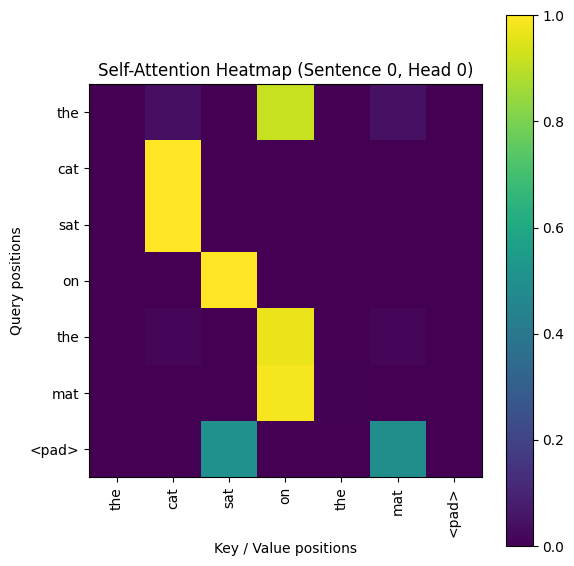

In [8]:
# ============================================================
#
# Components implemented:
#   - Tokenization + Embedding
#   - Sinusoidal positional encoding
#   - Self-attention (multi-head, 4 heads)
#   - Feed-forward layer
#   - Add & Norm (residual + LayerNorm)
#   - Show:
#       * Input tokens
#       * Final contextual embeddings
#       * Attention heatmap between words
# ============================================================

import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------------
# 1. Small sentence dataset
# ------------------------------------------------------------
# I created 10 simple sentences covering some basic relations.
sentences = [
    "the cat sat on the mat",
    "the dog chased the cat",
    "the cat chased the mouse",
    "the mouse ran away quickly",
    "a dog barked loudly at night",
    "the cat slept all day",
    "the bird flew over the house",
    "the dog and the cat are friends",
    "the mouse found some cheese",
    "the house is near the river"
]

# ------------------------------------------------------------
# 2. Tokenization + Vocabulary
# ------------------------------------------------------------
# Simple whitespace tokenizer, lowercase only.
tokenized = [s.lower().split() for s in sentences]

# Build vocabulary with special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

vocab = {PAD_TOKEN, UNK_TOKEN}
for sent in tokenized:
    vocab.update(sent)
vocab = sorted(list(vocab))

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

vocab_size = len(vocab)
print("Vocab size:", vocab_size)
print("Vocab:", vocab)

# Convert sentences to index sequences, with padding
max_len = max(len(s) for s in tokenized)
print("Max sentence length:", max_len)

def encode_sentence(words, max_len):
    idxs = [word2idx.get(w, word2idx[UNK_TOKEN]) for w in words]
    # pad with <pad> to max_len
    if len(idxs) < max_len:
        idxs += [word2idx[PAD_TOKEN]] * (max_len - len(idxs))
    return idxs[:max_len]

encoded = [encode_sentence(s, max_len) for s in tokenized]
input_ids = torch.tensor(encoded, dtype=torch.long, device=device)  # (batch_size, max_len)

batch_size = input_ids.size(0)
print("Input IDs shape:", input_ids.shape)  # (batch, seq_len)

# ------------------------------------------------------------
# 3. Positional Encoding (Sinusoidal)
# ------------------------------------------------------------

class SinusoidalPositionalEncoding(nn.Module):
    """
    Standard sinusoidal positional encoding from the Transformer paper.
    PE[pos, 2i]   = sin(pos / 10000^(2i/d_model))
    PE[pos, 2i+1] = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        # add positional encoding
        return x + self.pe[:, :seq_len, :]


# ------------------------------------------------------------
# 4. Multi-Head Self-Attention
# ------------------------------------------------------------

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len, d_model)
        mask: (batch_size, seq_len) or (batch_size, 1, 1, seq_len)
        returns:
            out: (batch_size, seq_len, d_model)
            attn_weights: (batch_size, num_heads, seq_len, seq_len)
        """
        batch_size, seq_len, _ = x.size()

        # Linear projections
        Q = self.W_q(x)  # (batch, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)

        # Split into heads: (batch, num_heads, seq_len, d_k)
        def split_heads(t):
            return t.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        Q = split_heads(Q)
        K = split_heads(K)
        V = split_heads(V)

        # Scaled dot-product attention
        # scores: (batch, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            # mask should broadcast to (batch, num_heads, seq_len, seq_len)
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn_weights = torch.softmax(scores, dim=-1)  # (batch, num_heads, seq_len, seq_len)

        # attention output
        context = torch.matmul(attn_weights, V)  # (batch, num_heads, seq_len, d_k)

        # concat heads
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        out = self.W_o(context)  # (batch, seq_len, d_model)
        return out, attn_weights


# ------------------------------------------------------------
# 5. Feed-Forward Network
# ------------------------------------------------------------

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


# ------------------------------------------------------------
# 6. Transformer Encoder Layer (1 layer)
# ------------------------------------------------------------

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = PositionwiseFeedForward(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        # Self-attention + Add & Norm
        attn_output, attn_weights = self.self_attn(x, mask=src_mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Feed-forward + Add & Norm
        ff_output = self.ff(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        return x, attn_weights


# ------------------------------------------------------------
# 7. Full Mini Encoder
# ------------------------------------------------------------

class MiniTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4, d_ff=128, max_len=100):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff)

    def forward(self, src_ids, src_mask=None):
        """
        src_ids: (batch_size, seq_len)
        """
        x = self.embedding(src_ids) * math.sqrt(self.d_model)  # (batch, seq_len, d_model)
        x = self.pos_encoder(x)
        x, attn_weights = self.encoder_layer(x, src_mask)
        return x, attn_weights


# ------------------------------------------------------------
# 8. Create Mask (optional: mask padding positions)
# ------------------------------------------------------------

# Simple padding mask: 1 where token != PAD, 0 where PAD
pad_idx = word2idx[PAD_TOKEN]
src_mask = (input_ids != pad_idx).unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, seq_len)

# ------------------------------------------------------------
# 9. Run the mini Transformer Encoder
# ------------------------------------------------------------

d_model = 64
num_heads = 4
d_ff = 128

encoder = MiniTransformerEncoder(vocab_size, d_model, num_heads, d_ff, max_len=max_len).to(device)
encoder.eval()  # no training here, just a forward pass for demonstration

with torch.no_grad():
    contextual_embeddings, attn_weights = encoder(input_ids, src_mask=src_mask)
    # contextual_embeddings: (batch_size, seq_len, d_model)
    # attn_weights: (batch_size, num_heads, seq_len, seq_len)

print("Contextual embeddings shape:", contextual_embeddings.shape)
print("Attention weights shape:", attn_weights.shape)

# ------------------------------------------------------------
# 10. Show Input Tokens and Final Contextual Embeddings
# ------------------------------------------------------------

print("\n=== Input tokens per sentence ===")
for i, sent_ids in enumerate(input_ids):
    tokens = [idx2word[idx.item()] for idx in sent_ids]
    print(f"Sentence {i}: {tokens}")

# Show contextual embedding for the first sentence
print("\n=== Contextual embeddings for sentence 0 (shape) ===")
print(contextual_embeddings[0].shape)   # (seq_len, d_model)
print("First 3 tokens' embeddings (sentence 0):")
print(contextual_embeddings[0, :3, :])  # print a few vectors

# ------------------------------------------------------------
# 11. Attention Heatmap between Words (for sentence 0, head 0)
# ------------------------------------------------------------

# Select first sentence, first head
sent_idx = 0
head_idx = 0
attn_for_sent = attn_weights[sent_idx, head_idx]  # (seq_len, seq_len)

# Convert to CPU for plotting
attn_matrix = attn_for_sent.cpu().numpy()
tokens = [idx2word[idx.item()] for idx in input_ids[sent_idx]]

plt.figure(figsize=(6, 6))
plt.imshow(attn_matrix, interpolation="nearest")
plt.title(f"Self-Attention Heatmap (Sentence {sent_idx}, Head {head_idx})")
plt.xlabel("Key / Value positions")
plt.ylabel("Query positions")
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
# Q3. Scaled Dot-Product Attention
# Implement the attention function:
#   Attention(Q, K, V) = softmax( (Q K^T) / sqrt(d_k) ) V
#
# Test with random Q, K, V and print:
#   - Attention weight matrix
#   - Output vectors
#   - Softmax stability check (before and after scaling)
# ============================================================

import math
import torch
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------------
# 1. Implement Scaled Dot-Product Attention
# ------------------------------------------------------------

def scaled_dot_product_attention(Q, K, V):
    """
    Q: (seq_len_q, d_k)
    K: (seq_len_k, d_k)
    V: (seq_len_k, d_v)   usually d_v = d_k, but not required

    Returns:
      attn_weights: (seq_len_q, seq_len_k)
      output: (seq_len_q, d_v)
    """
    d_k = Q.size(-1)

    # Raw attention scores (unscaled)
    scores = Q @ K.T   # (seq_len_q, seq_len_k)

    # Scale by sqrt(d_k) for stability
    scaled_scores = scores / math.sqrt(d_k)

    # Softmax over keys dimension
    attn_weights = F.softmax(scaled_scores, dim=-1)  # (seq_len_q, seq_len_k)

    # Weighted sum of values
    output = attn_weights @ V  # (seq_len_q, d_v)

    return attn_weights, output, scores, scaled_scores


# ------------------------------------------------------------
# 2. Create Random Q, K, V for Testing
# ------------------------------------------------------------

# I use a tiny example for clarity:
seq_len_q = 4
seq_len_k = 4
d_k = 8
d_v = 8

Q = torch.randn(seq_len_q, d_k, device=device)
K = torch.randn(seq_len_k, d_k, device=device)
V = torch.randn(seq_len_k, d_v, device=device)

print("Q shape:", Q.shape)
print("K shape:", K.shape)
print("V shape:", V.shape)

# ------------------------------------------------------------
# 3. Run Scaled Dot-Product Attention
# ------------------------------------------------------------

attn_weights, output, scores_unscaled, scores_scaled = scaled_dot_product_attention(Q, K, V)

# Move to CPU for nicer printing
attn_weights_cpu = attn_weights.detach().cpu()
output_cpu = output.detach().cpu()
scores_unscaled_cpu = scores_unscaled.detach().cpu()
scores_scaled_cpu = scores_scaled.detach().cpu()

# ------------------------------------------------------------
# 4. Print Results
# ------------------------------------------------------------

print("\n=== Raw Attention Scores (Q K^T) BEFORE scaling ===")
print(scores_unscaled_cpu)

print("\n=== Scaled Attention Scores (Q K^T / sqrt(d_k)) ===")
print(scores_scaled_cpu)

print("\n=== Attention Weights (softmax over scaled scores) ===")
print(attn_weights_cpu)

print("\n=== Output Vectors (Attention(Q,K,V)) ===")
print(output_cpu)

# ------------------------------------------------------------
# 5. Softmax Stability Check
# ------------------------------------------------------------
# Here I compare softmax on:
#   - unscaled scores
#   - scaled scores
# and show how scaling avoids extremely peaky distributions.

softmax_unscaled = F.softmax(scores_unscaled_cpu, dim=-1)
softmax_scaled = F.softmax(scores_scaled_cpu, dim=-1)

print("\n=== Softmax on UN-SCALED scores ===")
print(softmax_unscaled)

print("\n=== Softmax on SCALED scores (correct formula) ===")
print(softmax_scaled)

# To make the stability point clearer, I also print the
# max absolute value of scores before and after scaling.
print("\n=== Score statistics ===")
print("Unscaled scores: mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}".format(
    scores_unscaled_cpu.mean().item(),
    scores_unscaled_cpu.std().item(),
    scores_unscaled_cpu.max().item(),
    scores_unscaled_cpu.min().item()
))
print("Scaled scores:   mean = {:.4f}, std = {:.4f}, max = {:.4f}, min = {:.4f}".format(
    scores_scaled_cpu.mean().item(),
    scores_scaled_cpu.std().item(),
    scores_scaled_cpu.max().item(),
    scores_scaled_cpu.min().item()
))


Using device: cuda
Q shape: torch.Size([4, 8])
K shape: torch.Size([4, 8])
V shape: torch.Size([4, 8])

=== Raw Attention Scores (Q K^T) BEFORE scaling ===
tensor([[-2.9231,  1.6705,  2.1829, -3.8054],
        [-3.8772, -1.2850,  5.1514,  0.5424],
        [-0.9399, -1.0429,  3.3317, -2.8657],
        [ 0.8756, -3.4032,  0.2051,  3.4454]])

=== Scaled Attention Scores (Q K^T / sqrt(d_k)) ===
tensor([[-1.0335,  0.5906,  0.7718, -1.3454],
        [-1.3708, -0.4543,  1.8213,  0.1918],
        [-0.3323, -0.3687,  1.1779, -1.0132],
        [ 0.3096, -1.2032,  0.0725,  1.2181]])

=== Attention Weights (softmax over scaled scores) ===
tensor([[0.0776, 0.3937, 0.4719, 0.0568],
        [0.0307, 0.0767, 0.7464, 0.1463],
        [0.1429, 0.1378, 0.6470, 0.0723],
        [0.2227, 0.0491, 0.1757, 0.5525]])

=== Output Vectors (Attention(Q,K,V)) ===
tensor([[-1.2653e-01,  5.9448e-02, -6.6461e-02,  3.7546e-01,  3.2777e-01,
         -8.1854e-02,  1.4343e-01,  8.1319e-04],
        [ 1.6435e-02,  1.3801e